In [1]:
from segmentation_models_pytorch import Unet

model = Unet(encoder_name="resnet34",  # backbone
             encoder_weights="imagenet",  # pretrained
             in_channels=1,
             classes=1)  # o più se multi-classe

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = model.to(device) 

Using device: cuda


In [3]:
import cv2
import numpy as np


In [4]:
import torchvision.transforms as T

# Funzione per caricare l'immagine, applicare la conversione e la normalizzazione
def preprocess_image_to_RGB(image_path):
    # 1. Carica l'immagine usando OpenCV (la carica come BGR)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Legge in bianco e nero (grayscale)

    # 2. Se l'immagine è già in scala di grigi, aggiungi i 2 canali
    # Aggiungi due dimensioni per imitare un'immagine RGB fittizia
    img_rgb = np.stack([img] * 3, axis=-1)  # Ripete il canale 1 (grayscale) su 3 canali
    
    # 3. Converti in un formato Tensor di PyTorch e normalizza tra 0 e 1
    img_tensor = torch.tensor(img_rgb, dtype=torch.float32) / 255.0  # [0,1]

    # 4. Cambia la forma da [H, W, C] a [C, H, W] per PyTorch
    img_tensor = img_tensor.permute(2, 0, 1)  # [C, H, W]

    # 5. Normalizzazione (mean e std sono quelli di ImageNet)
    transform = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    img_tensor = transform(img_tensor)  # Applica la normalizzazione

    # Aggiungi una dimensione per il batch (batch size = 1)
    img_tensor = img_tensor.unsqueeze(0)  # [1, C, H, W]
    
    return img_tensor


# Funzione per caricare l'immagine, applicare la conversione e la normalizzazione
def preprocess_image(image_path):
    # 1. Carica l'immagine usando OpenCV (la carica come BGR)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Legge in bianco e nero (grayscale)
    
    # 3. Converti in un formato Tensor di PyTorch e normalizza tra 0 e 1
    img_tensor = torch.tensor(img, dtype=torch.float32) / 255.0  # [0,1]
    img_tensor = img_tensor.unsqueeze(0)  # Aggiungi un canale (grayscale) [1, H, W]

    # 5. Normalizzazione (mean e std sono quelli di ImageNet)
    transform = T.Normalize(mean=[0.485], std=[0.229])

    img_tensor = transform(img_tensor)  # Applica la normalizzazione

    # Aggiungi una dimensione per il batch (batch size = 1)
    img_tensor = img_tensor.unsqueeze(0)  # [1, C, H, W]
    
    return img_tensor


# Esempio di utilizzo
image_path = '../output_blob/stretched/p35.png'  # Sostituisci con il percorso dell'immagine
input_image = preprocess_image(image_path)

# Verifica la forma finale dell'immagine preprocessata
print(input_image.shape)  # Dovrebbe essere [1, 3, H, W]



torch.Size([1, 1, 660, 920])


In [5]:
model.eval()
with torch.no_grad():
    logits = model(input_image.to(device))
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

In [6]:
preds

tensor([[[[0., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 0.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 0.]]]], device='cuda:0')

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

common_transforms = A.Compose([
    A.RandomCrop(height=600, width=600),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    # ToTensorV2()

])

# Not for mask
image_transforms = A.Compose([
    A.RandomBrightnessContrast(p=0.2),  # Solo per l'immagine
    ToTensorV2()
])

c:\Users\lgand\anaconda3\envs\DL\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [8]:
from datamodule import BinarySegmentationDataset

ds = BinarySegmentationDataset(
    images_dir='../output_blob/stretched/',
    masks_dir='../output_blob/masks/',
    common_transform= common_transforms,
    image_transform= image_transforms,
)

In [9]:

        # self.train_common_transform = A.Compose([
        #     A.ShiftScaleRotate(p=0.2),
        #     A.RandomCrop(height=img_size[0], width=img_size[1]),
        #     A.HorizontalFlip(p=0.5),
        #     A.VerticalFlip(p=0.5),
        #     A.RandomRotate90(p=0.5),
        #     A.Normalize(mean=(0.5,), std=(0.5,)),
        # ])
        # self.train_image_transform = A.Compose([
        #     A.RandomBrightnessContrast(p=0.2),
        #     A.ToTensorV2(),
        # ])

        # self.val_common_transform = A.Compose([
        #     A.RandomCrop(height=img_size[0], width=img_size[1]),
        #     A.Normalize(mean=(0.5,), std=(0.5,)),
        # ])
        # self.val_image_transform =  A.Compose([
        #     A.ToTensorV2(),
        # ])

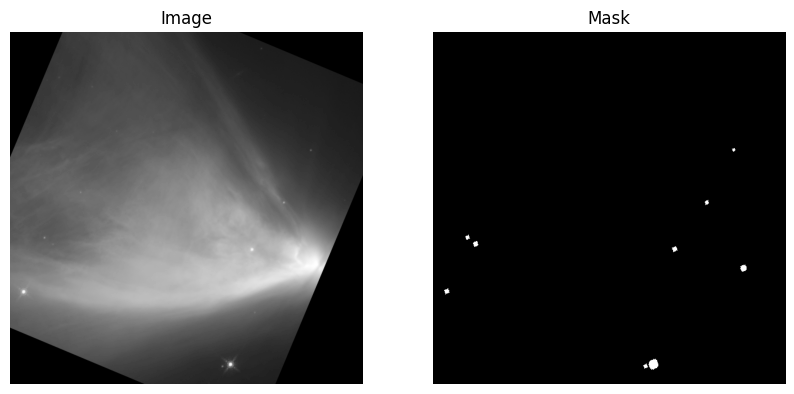

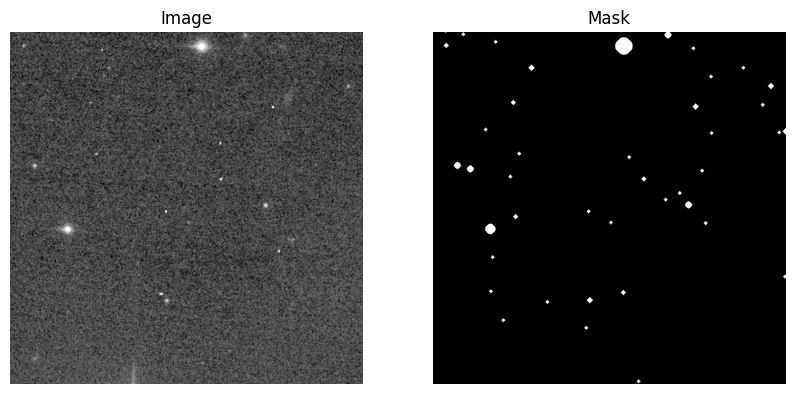

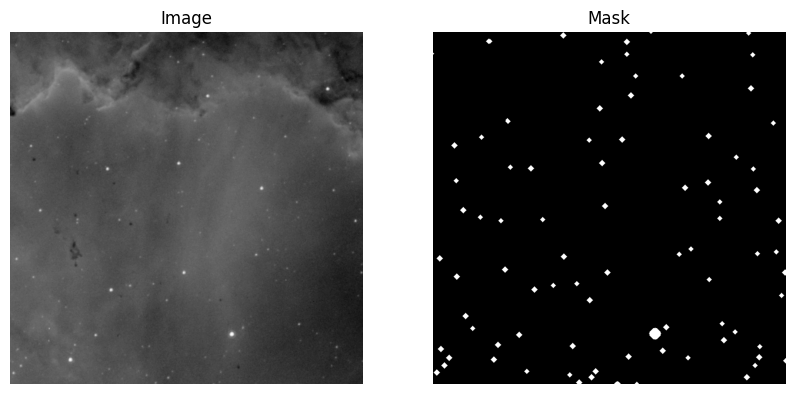

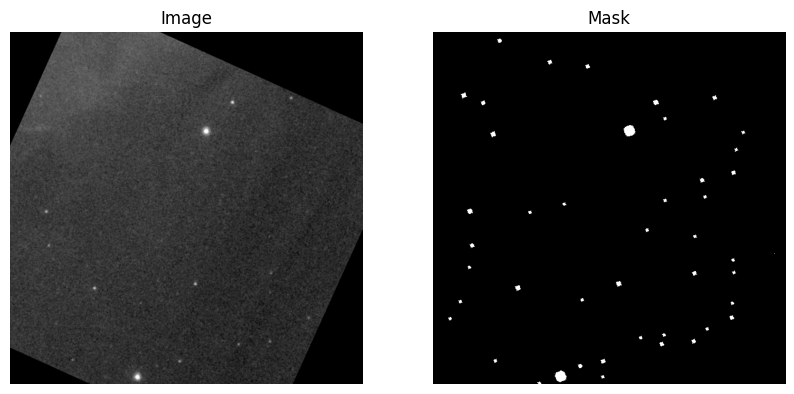

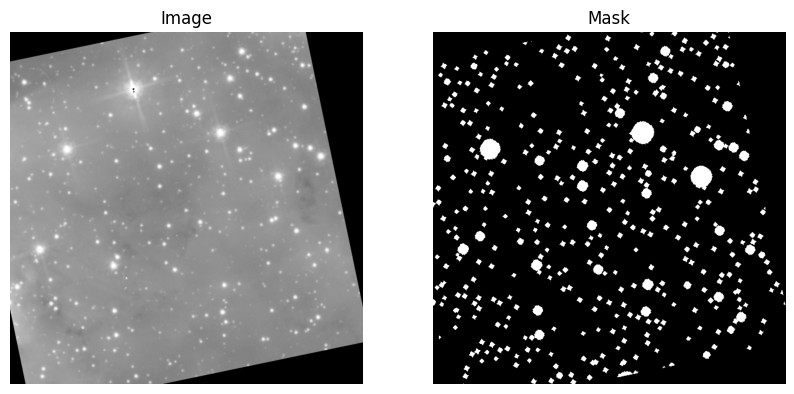

In [10]:
import matplotlib.pyplot as plt
for im, mask in ds:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(im.permute(1, 2, 0).squeeze().numpy(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(mask.squeeze().numpy(), cmap='gray')
    axs[1].set_title('Mask')
    for ax in axs:
        ax.axis('off')
    plt.show()
    

In [ ]:
from datamodule import BinarySegmentationDataModule
dm = BinarySegmentationDataModule(
    train_images_dir='../output_blob/stretched/',
    train_masks_dir='../output_blob/masks/',
    val_images_dir='../output_blob/stretched/',
    val_masks_dir='../output_blob/masks/',

    transforms= {"train_common": common_transforms,
                 "train_image": image_transforms,
                 "val_common": common_transforms,
                 "val_image": image_transforms},
    img_size=(600, 600),
    batch_size=4,
    num_workers=1,
)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

In [12]:
for images, masks in train_loader:
    print(images.shape)  # Dovrebbe essere [batch_size, 3, H, W]
    print(masks.shape)   # Dovrebbe essere [batch_size, 1, H, W]
    

torch.Size([4, 1, 600, 600])
torch.Size([4, 1, 600, 600])
torch.Size([1, 1, 600, 600])
torch.Size([1, 1, 600, 600])


Il dataloader è lentissimo

In [14]:
import time

for batch in train_loader:
    pass

KeyboardInterrupt: 